## Семинар 3 "Определение ключевых точек лица"

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  22 марта 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [0]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter
from torch.nn import ReLU,Conv2d,MaxPool2d, BatchNorm2d
from torch.autograd import Variable
# Ignore warnings
import warnings


try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss




Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


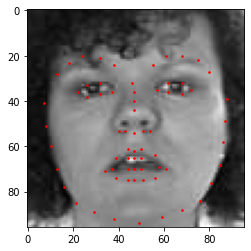

In [6]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].to_numpy().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [0]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)[None]
        landmarks = self.landmarks_frame.iloc[idx, 1:].to_numpy().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [0]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

In [0]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [0]:
class Net(Module):
    def __init__(self, activation=ReLU(), latent_size=200):
        super().__init__()
        self.conv1=Sequential(Conv2d(1,32,3,padding=1),BatchNorm2d(32),ReLU(),
                              Conv2d(32,32,3,padding=1),MaxPool2d(2),
                              BatchNorm2d(32),ReLU())
        self.conv2=Sequential(Conv2d(32,64,3,padding=1),BatchNorm2d(64),ReLU(),
                              Conv2d(64,64,3,padding=1),MaxPool2d(2),
                              BatchNorm2d(64),ReLU())
        self.conv3=Sequential(Conv2d(64,128,3,padding=1),BatchNorm2d(128),ReLU(),
                              Conv2d(128,128,3,padding=1),MaxPool2d(2),
                              BatchNorm2d(128),ReLU())
        self.conv4=Sequential(Conv2d(128,256,3,padding=1),BatchNorm2d(256),ReLU(),
                              Conv2d(256,256,3,padding=1),MaxPool2d(2),
                              BatchNorm2d(256),ReLU())
        self.fc1 = Linear(6*6*256, 1024)
        self.fc2 = Linear(1024, 68 * 2)
    def forward(self, x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.fc1(x.view(x.shape[0],-1))
        y=self.fc2(x)
        return y.view(-1,68,2)

In [0]:
torch.cuda.is_available()

True

In [0]:
network = Net()
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="logs")

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 70

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [0]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()

best=np.inf
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    global best
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)

    best=min(best,l2)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))
   

In [23]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 70  Avg MSE: 6.40 / 7.79 Avg MAE: 1.95 / 2.08

State:
	iteration: 6860
	epoch: 70
	epoch_length: 98
	max_epochs: 70
	output: 7.070932388305664
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: 12

In [24]:
best

5.523997364440303

Лучший результат = 5.5



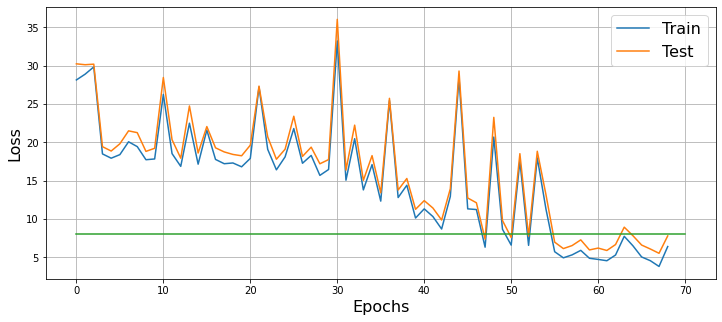

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.plot(np.array([0,70]),np.array([8,8]))
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

Видно, что начиная с 55 эпохи MSE меньше 8